In [ ]:
import pandas as pd
from decimal import Decimal, ROUND_HALF_UP
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

In [ ]:
# Help function
def round_up(number, num_digits):
    if num_digits > 0:
        res = round_up(number * 10, num_digits - 1) / 10
    else:
        res = Decimal(number * 10 ** num_digits).quantize(Decimal('1'), rounding=ROUND_HALF_UP) * 10 ** -num_digits
    return res

In [ ]:
# Read location, round lng and lat
dfl = pd.read_csv(r'C:\Users\yeych\Downloads\locations.csv')
dfl['lat'] = dfl['lat'].map(lambda x: '%.4f'%x)
dfl['lat'] = pd.to_numeric(dfl['lat'])
dfl['lng'] = dfl['lng'].map(lambda x: '%.4f'%x)
dfl['lng'] = pd.to_numeric(dfl['lng'])

# Keep centreline_type =2, this corresponds with an intersection
dfl = dfl[dfl['centreline_type'] == 2]

# Clean location dataset
dfl = dfl[['location_id','lng','lat']]

print(dfl)

      location_id      lng      lat
0            1146 -79.2463  43.7733
3            3925 -79.4753  43.6368
4            3926 -79.4858  43.6483
5            3927 -79.3284  43.6592
6            3928 -79.4292  43.6314
...           ...      ...      ...
5790        43136 -79.4533  43.7601
5791        43137 -79.4536  43.7609
5792        43138 -79.4539  43.7617
5793        43139 -79.4543  43.7625
5794        43140 -79.4187  43.7680

[5570 rows x 3 columns]


In [ ]:
# Read collisions 2014-2021, use as y
dfc = pd.read_csv(r'C:\Users\yeych\Downloads\Traffic Collisions - 4326.csv')
dfc['OccurrenceDate'] = dfc['OccurrenceDate'].str.slice(0,10)
dfc['OccurrenceDate'] = pd.to_datetime(dfc['OccurrenceDate'])

# Create lng and lat column, keep 4 digits
dfc['geometry']= dfc['geometry'].str.slice(34,-2)

dfc['lng'] = dfc['geometry'].str.split(', ',expand=True)[0]
dfc['lng'] = pd.to_numeric(dfc['lng'])
dfc['lng'] = dfc['lng'].map(lambda x: '%.4f'%x)
dfc['lng'] = pd.to_numeric(dfc['lng'])


dfc['lat'] = dfc['geometry'].str.split(',',expand=True)[1]
dfc['lat'] = pd.to_numeric(dfc['lat'])
dfc['lat'] = dfc['lat'].map(lambda x: '%.4f'%x)
dfc['lat'] = pd.to_numeric(dfc['lat'])

# Drop extreme values
dfc = dfc[(dfc['lng'] < 0) & (dfc['lat'] > 0)]

# Create location id column
dfc_id = pd.merge(dfc,dfl,on=['lng','lat'])

print(dfc_id)

           _id   EventUniqueId OccurrenceDate      Month Day_of_Week  Year  \
0            1  GO-20141340438     2014-01-14    January     Tuesday  2014   
1        66974  GO-20151260806     2015-07-24       July      Friday  2015   
2        77850   GO-2015616846     2015-04-14      April     Tuesday  2015   
3       130482   GO-2015819980     2015-05-17        May      Sunday  2015   
4       132322  GO-20161196513     2016-07-08       July      Friday  2016   
...        ...             ...            ...        ...         ...   ...   
188189  488317  GO-20212437908     2021-12-18   December    Saturday  2021   
188190  488593  GO-20212330287     2021-12-03   December      Friday  2021   
188191  511936  GO-20218020889     2021-09-08  September   Wednesday  2021   
188192  521005  GO-20218031822     2021-12-01   December   Wednesday  2021   
188193  521341  GO-20218031723     2021-11-08   November      Monday  2021   

        Hour Division Atom              Neighbourhood  Fataliti

In [ ]:
# Create a dataframe of collisions number for each location id from 2014 to 2021
dfci = dfc_id.groupby(['location_id']).size().to_frame\
        ('Collision_Number_at_Each_Intersection')
print(dfci)

             Collision_Number_at_Each_Intersection
location_id                                       
3927                                           288
3931                                           276
3932                                             6
3933                                             5
3934                                           125
...                                            ...
43092                                           32
43128                                            5
43136                                            2
43137                                            3
43140                                            5

[3015 rows x 1 columns]


In [ ]:
# Read TrafficVolume 2010-2019, drop 2010-2013
dft1 = pd.read_csv(r'C:\Users\yeych\Downloads\raw-data-2010-2019.csv')
dft1['count_date'] = pd.to_datetime(dft1['count_date'])
dft1 = dft1[dft1['count_date'] >= '2014-01-01']

# Read TrafficVolume 2020-2022, drop 2022
dft2 = pd.read_csv(r'C:\Users\yeych\Downloads\raw-data-2020-2029.csv')
dft2['count_date'] = pd.to_datetime(dft2['count_date'])
dft2 = dft2[dft2['count_date'] < '2022-01-01']

# Join two TrafficVolume tables, 2014-2022
dft = pd.concat([dft1,dft2], ignore_index=True)

# Keep centreline_type =2, this corresponds with an intersection
dft = dft[dft['centreline_type'] == 2]

# Keep 4 digits for lng and lat column
dft['lng'] = dft['lng'].map(lambda x: round_up(x,4))
dft['lng'] = pd.to_numeric(dft['lng'])
dft['lat'] = dft['lat'].map(lambda x: round_up(x,4))
dft['lat'] = pd.to_numeric(dft['lat'])

print(dft)

          _id  count_id count_date  location_id  \
0       82775     30565 2014-01-09         4517   
1       82776     30565 2014-01-09         4517   
2       82777     30565 2014-01-09         4517   
3       82778     30565 2014-01-09         4517   
4       82779     30565 2014-01-09         4517   
...       ...       ...        ...          ...   
206531  70143     44053 2021-12-15         4410   
206532  70144     44053 2021-12-15         4410   
206533  70145     44053 2021-12-15         4410   
206534  70146     44053 2021-12-15         4410   
206535  70147     44053 2021-12-15         4410   

                                         location      lng      lat  \
0             DANFORTH AVE AT SIBLEY AVE (PX 178) -79.2927  43.6902   
1             DANFORTH AVE AT SIBLEY AVE (PX 178) -79.2927  43.6902   
2             DANFORTH AVE AT SIBLEY AVE (PX 178) -79.2927  43.6902   
3             DANFORTH AVE AT SIBLEY AVE (PX 178) -79.2927  43.6902   
4             DANFORTH AVE AT SI

In [ ]:
# Sum car, truck, bus, pedestrian, cyclist, other for each observation
dft['car_total'] = dft.iloc[:,12:24].sum(axis=1)
dft['truck_total'] = dft.iloc[:,24:36].sum(axis=1)
dft['bus_total'] = dft.iloc[:,36:48].sum(axis=1)
dft['pedestrian_total'] = dft.iloc[:,48:52].sum(axis=1)
dft['cyclist_total'] = dft.iloc[:,52:56].sum(axis=1)
dft['other_total'] = dft.iloc[:,56:60].sum(axis=1)

# Clean traffic volume dataset
dft = dft[['location_id','car_total','truck_total','bus_total','pedestrian_total',\
          'cyclist_total','other_total']]
print(dft)

        location_id  car_total  truck_total  bus_total  pedestrian_total  \
0              4517      278.0         34.0       13.0               7.0   
1              4517      329.0         39.0        7.0              13.0   
2              4517      399.0         33.0       11.0               7.0   
3              4517      403.0         32.0        9.0               9.0   
4              4517      298.0         44.0       10.0              15.0   
...             ...        ...          ...        ...               ...   
206531         4410      257.0          1.0        3.0              14.0   
206532         4410      282.0          6.0        2.0               8.0   
206533         4410      299.0          4.0        7.0              23.0   
206534         4410      240.0          0.0        3.0               5.0   
206535         4410      279.0          4.0        4.0               7.0   

        cyclist_total  other_total  
0                 2.0          0.0  
1            

In [ ]:
# Sum car, truck, bus, pedestrian, cyclist, other for each location id from 2014 to 2021
dftc = dft.groupby(by=['location_id'])['car_total'].sum().reset_index()
dftt = dft.groupby(by=['location_id'])['truck_total'].sum().reset_index()
dftb = dft.groupby(by=['location_id'])['bus_total'].sum().reset_index()
dftp = dft.groupby(by=['location_id'])['pedestrian_total'].sum().reset_index()
dftcy = dft.groupby(by=['location_id'])['cyclist_total'].sum().reset_index()
dfto = dft.groupby(by=['location_id'])['other_total'].sum().reset_index()

# Merge the sum dataframe
df1 = pd.merge(dftc,dftt,on=['location_id'])
df2 = pd.merge(df1,dftb,on=['location_id'])
df3 = pd.merge(df2,dftp,on=['location_id'])
df4 = pd.merge(df3,dftcy,on=['location_id'])
df5 = pd.merge(df4,dfto,on=['location_id'])
df5

,location_id,car_total,truck_total,bus_total,pedestrian_total,cyclist_total,other_total
0,1146,14349.0,277.0,513.0,168.0,1.0,0.0
1,3926,52490.0,1155.0,62.0,4479.0,325.0,563.0
2,3928,26437.0,1107.0,50.0,20.0,1.0,3355.0
3,3929,24384.0,583.0,45.0,535.0,181.0,15965.0
4,3930,23415.0,1053.0,60.0,189.0,153.0,0.0
...,...,...,...,...,...,...,...
3483,42437,1186.0,52.0,80.0,904.0,98.0,0.0
3484,42449,7332.0,192.0,38.0,257.0,90.0,0.0
3485,42521,11490.0,247.0,98.0,153.0,12.0,0.0
3486,42522,11219.0,237.0,97.0,168.0,11.0,0.0


In [ ]:
# Final dataset
df6 = pd.merge(df5,dfci,on=['location_id'])
df6
df6.to_csv(r'C:\Users\yeych\Desktop\lm.csv', index = False)

In [ ]:
# Traffic volume proportion
x = np.array([df6['car_total'].sum(),df6['truck_total'].sum(),df6['bus_total'].sum(),\
             df6['pedestrian_total'].sum(),df6['cyclist_total'].sum(),df6['other_total'].sum()])
dfx = pd.DataFrame(x)
dfx
#dfx.to_csv(r'C:\Users\yeych\Desktop\pie.csv', index = False)


,0
0,40597464.0
1,1653471.0
2,698180.0
3,8077310.0
4,896235.0
5,1753.0


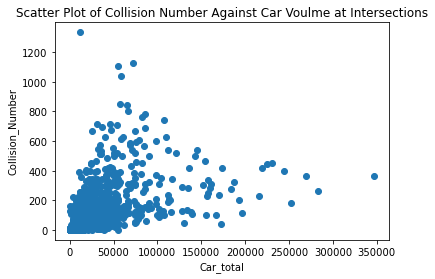

In [ ]:
# Explore the dependence between each factor and the response variable
y = df6['Collision_Number_at_Each_Intersection']
x1 = df6['car_total']
plt.scatter(x1, y)
plt.title('Scatter Plot of Collision Number Against Car Voulme at Intersections')
plt.xlabel("Car_total")
plt.ylabel("Collision_Number")
plt.show()

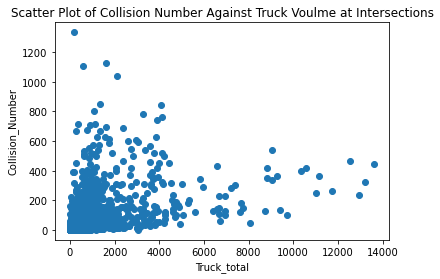

In [ ]:
y = df6['Collision_Number_at_Each_Intersection']
x2 = df6['truck_total']
plt.scatter(x2, y)
plt.title('Scatter Plot of Collision Number Against Truck Voulme at Intersections')
plt.xlabel("Truck_total")
plt.ylabel("Collision_Number")
plt.show()

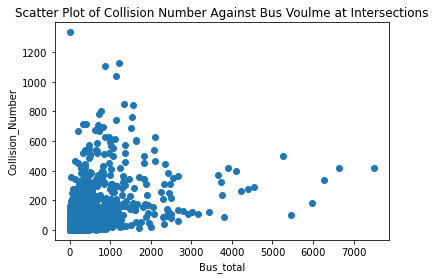

In [ ]:
y = df6['Collision_Number_at_Each_Intersection']
x3 = df6['bus_total']
plt.scatter(x3, y)
plt.title('Scatter Plot of Collision Number Against Bus Voulme at Intersections')
plt.xlabel("Bus_total")
plt.ylabel("Collision_Number")
plt.show()

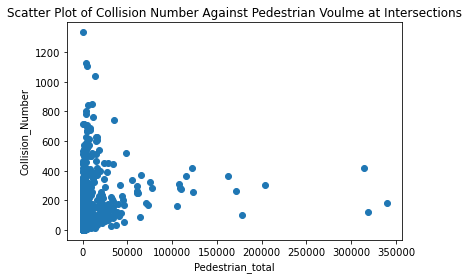

In [ ]:
y = df6['Collision_Number_at_Each_Intersection']
x4 = df6['pedestrian_total']
plt.scatter(x4, y)
plt.title('Scatter Plot of Collision Number Against Pedestrian Voulme at Intersections')
plt.xlabel("Pedestrian_total")
plt.ylabel("Collision_Number")
plt.show()

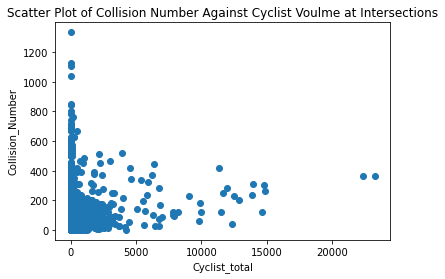

In [ ]:
y = df6['Collision_Number_at_Each_Intersection']
x5 = df6['cyclist_total']
plt.scatter(x5, y)
plt.title('Scatter Plot of Collision Number Against Cyclist Voulme at Intersections')
plt.xlabel("Cyclist_total")
plt.ylabel("Collision_Number")
plt.show()

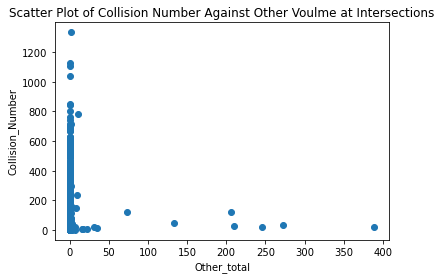

In [ ]:
y = df6['Collision_Number_at_Each_Intersection']
x6 = df6['other_total']
plt.scatter(x6, y)
plt.title('Scatter Plot of Collision Number Against Other Voulme at Intersections')
plt.xlabel("Other_total")
plt.ylabel("Collision_Number")
plt.show()